# Project Work - IRM24
## Jürgen Aumayr & Natalia Trudova

## Random Forest

### Datenimport und Vorverarbeitung

Der erste Codeblock ist für den Import der notwendigen Bibliotheken und das Laden der Daten zuständig.

In [1]:
# Importieren der notwendigen Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.tree import plot_tree

# Optimierte Datentypen definieren
dtypes = {
    'PassengerId': 'int32',  # 32-bit Integer für IDs ist ausreichend
    'Survived': 'int8',      # 8-bit Integer für binäre Werte (0/1)
    'Pclass': 'int8',        # 8-bit Integer für kleine Kategorien (1-3)
    'Name': 'str',           # String für Namen
    'Sex': 'category',       # Kategorie-Typ für höhere Effizienz bei wiederholten Werten
    'Age': 'float32',        # 32-bit Float statt Standard 64-bit
    'SibSp': 'int8',         # 8-bit Integer für kleine Zahlen
    'Parch': 'int8',         # 8-bit Integer für kleine Zahlen
    'Ticket': 'str',         # String für Ticketnummern
    'Fare': 'float32',       # 32-bit Float für Fahrpreise
    'Cabin': 'str',          # String für Kabinennummern
    'Embarked': 'category'   # Kategorie-Typ für Einschiffungshäfen (S, C, Q)
}

# Titanic-Daten einlesen
train_df = pd.read_csv('data/train.csv', dtype=dtypes)

# Ersten drei Zeilen des Datensatzes anzeigen
display(train_df.head(3))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250000,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283302,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925000,NaN,S


### Feature Engineering

Hier werden neue Features erstellt und bestehende transformiert:

* 'Sex' wird in numerische Werte umgewandelt (0 für weiblich, 1 für männlich).
* 'Age' wird in Kategorien eingeteilt (1: 0-18, 2: 19-60, 3: 61+).
* 'Fare' wird in Quartile eingeteilt (0-3).
* 'Embarked' wird in numerische Werte umgewandelt.
* 'Has_Cabin' wird als binäres Feature erstellt.
* 'FamilySize' und 'IsAlone' werden aus 'SibSp' und 'Parch' berechnet.
* 'Title' wird aus dem 'Name' extrahiert und kategorisiert.

In [2]:
def preprocess_features(df):
    """
    Bereitet die Titanic-Daten für das Modelltraining vor und
    erzeugt optimierte Features aus den Rohdaten.
    """
    # Kopie erstellen, um Originaldaten nicht zu verändern
    dataset = df.copy()
    
    # Geschlecht in numerisch konvertieren
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1})
    
    # Fehlende Alterswerte mit Median füllen - nach Klasse und Geschlecht gruppiert
    age_median = dataset.groupby(['Pclass', 'Sex'])['Age'].transform('median')
    dataset['Age'] = dataset['Age'].fillna(age_median)

    # NaN-Werte durch den Median ersetzen
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
    
    # Alter in Kategorien einteilen
    dataset['Age'] = pd.cut(
        dataset['Age'], 
        bins=[0, 18, 60, np.inf], 
        labels=[1, 2, 3]
    ).astype('int8')
    
    # Fahrpreise in Quartile einteilen für bessere Vergleichbarkeit
    dataset['Fare'] = pd.qcut(
        dataset['Fare'], 
        q=4, 
        labels=[0, 1, 2, 3],
        duplicates='drop'  # Verhindert Fehler bei doppelten Grenzwerten
    ).astype('int8')
    
    # Einschiffungshafen in numerische Werte umwandeln
    dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode()[0])
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype('int8')
    
    # Binäres Merkmal: Hat der Passagier eine Kabinennummer oder nicht?
    dataset['Has_Cabin'] = (dataset['Cabin'].notna()).astype('int8')
    
    # Berechnung der Familiengröße und Alleinreisenden-Status
    dataset['FamilySize'] = (dataset['SibSp'] + dataset['Parch'] + 1).astype('int8')
    dataset['IsAlone'] = (dataset['FamilySize'] == 1).astype('int8')
    
    # Titel aus Namen extrahieren mit regulärem Ausdruck - effizienter als Split
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Titel-Mapping für Kategorisierung
    title_mapping = {
        "Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5
    }
    
    # Seltenere Titel zusammenfassen, um Overfitting zu vermeiden
    rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 
                   'Major', 'Rev', 'Sir', 'Jonkheer', 'Mlle', 'Mme', 'Ms']
    dataset['Title'] = dataset['Title'].replace(rare_titles, 'Rare')
    dataset['Title'] = dataset['Title'].map(title_mapping).fillna(5).astype('int8')
    
    return dataset

# Daten vorverarbeiten und relevante Features auswählen
processed_df = preprocess_features(train_df)
features_df = processed_df[['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 
                            'Fare', 'Embarked', 'Has_Cabin', 'FamilySize', 
                            'IsAlone', 'Title']]

# Vorverarbeitete Features anzeigen
display(features_df.head(3))

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,2,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,2,0,1,0,0,1,1,4


### Datenaufteilung

In [3]:
# Features und Zielvariable trennen
X = features_df.drop('Survived', axis=1)
y = features_df['Survived']

# Daten aufteilen: Trainings- und Validierungsset (80% Training / 20% Test)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

### Modelltraining mit Random Forest

Hier wird ein Random Forest-Modell trainiert. Die Hyperparameter werden mit GridSearchCV optimiert.

In [4]:
# Hyperparameter-Grid für Random Forest
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [4, 6],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

# GridSearchCV für Hyperparameter-Tuning verwenden
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1,
)

# Modell trainieren
grid_search_rf.fit(X_train, y_train)

# Beste Parameter anzeigen
print(f"Beste Parameter: {grid_search_rf.best_params_}")

Beste Parameter: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


### Evaluierung des Modells

Das optimierte Modell wird auf dem Validierungsset getestet. Die Accuracy sowie ein Klassifikationsbericht werden ausgegeben.

In [5]:
# Bestes Modell auswählen und Vorhersagen treffen
best_rf_model = grid_search_rf.best_estimator_
val_predictions = best_rf_model.predict(X_val)

# Genauigkeit berechnen
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validierungsgenauigkeit: {val_accuracy:.4f}")

# Klassifikationsbericht ausgeben
print("Klassifikationsbericht:")
print(classification_report(y_val, val_predictions, target_names=['Gestorben', 'Überlebt']))

Validierungsgenauigkeit: 0.7989
Klassifikationsbericht:
              precision    recall  f1-score   support

   Gestorben       0.81      0.87      0.84       110
    Überlebt       0.77      0.68      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



### Feature-Wichtigkeit analysieren

Die Wichtigkeit der Features im Random Forest wird visualisiert.

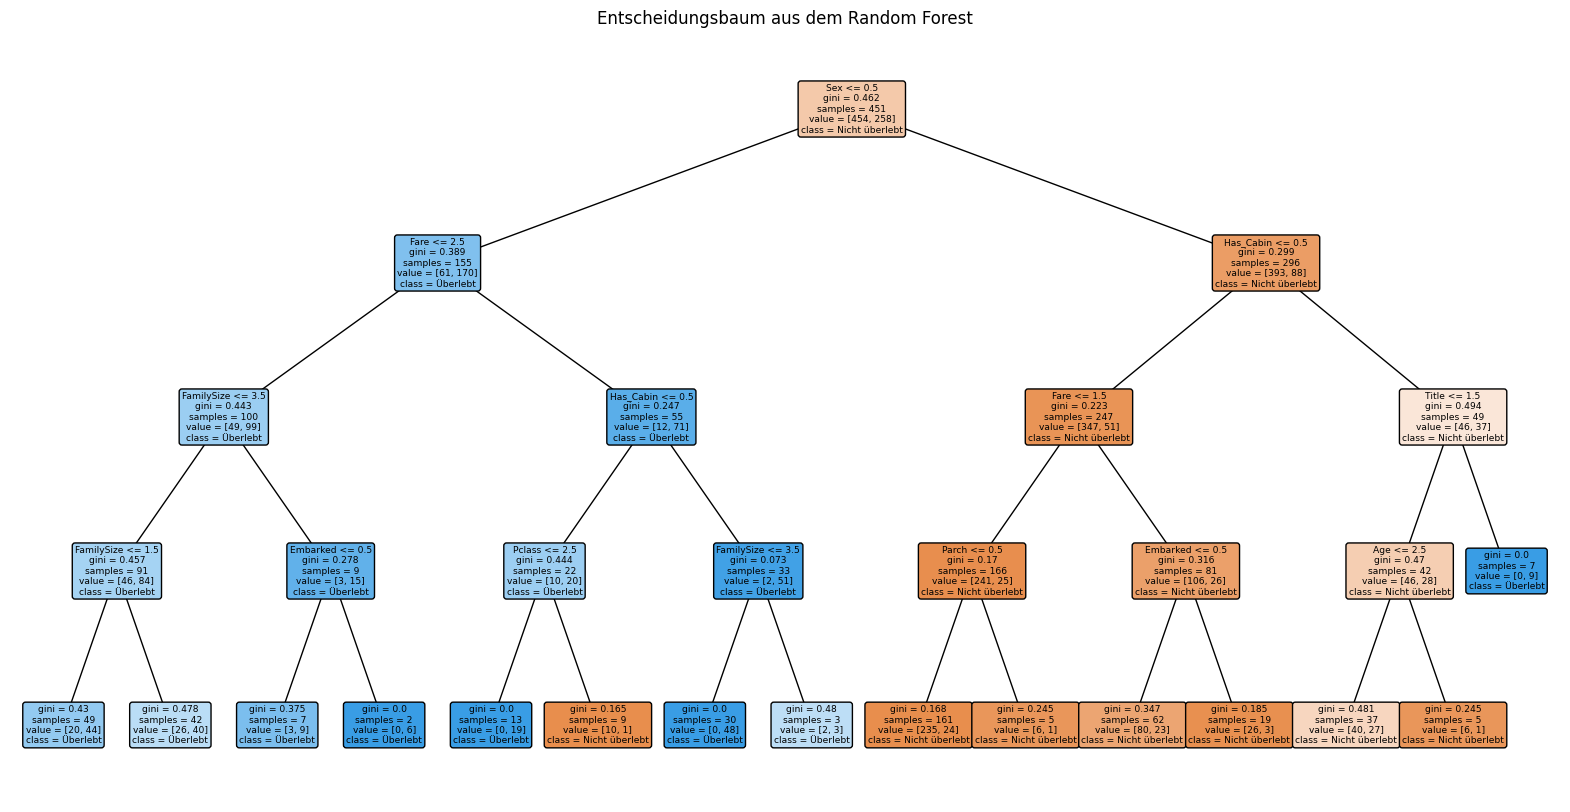

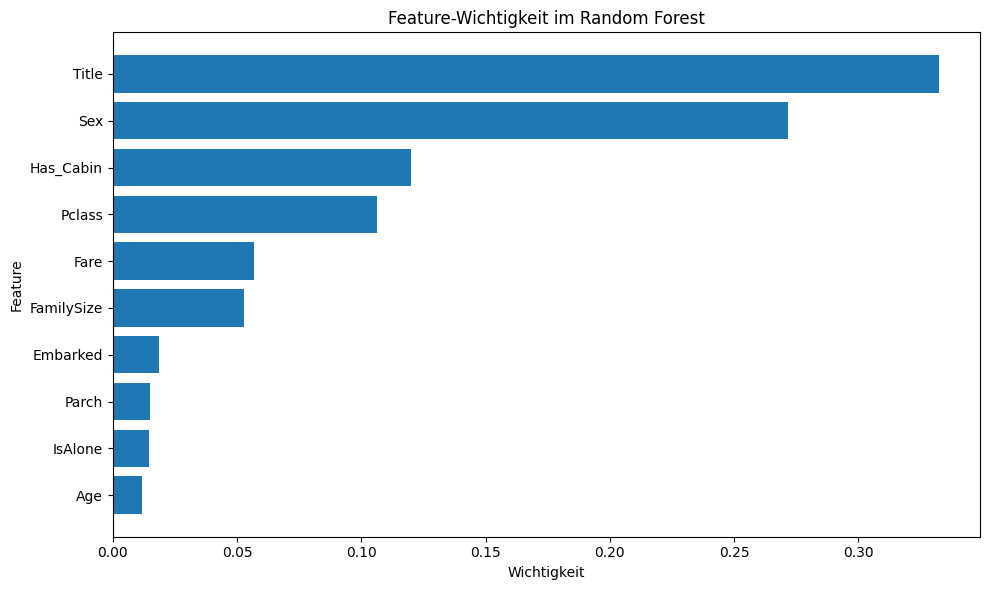

In [11]:
# Einen Baum aus dem Random Forest auswählen
tree = best_rf_model.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(tree,
          feature_names=X.columns,
          class_names=['Nicht überlebt', 'Überlebt'],
          filled=True,
          rounded=True)
plt.title("Entscheidungsbaum aus dem Random Forest")
plt.savefig('random_forest_tree.png')  # Hochauflösende Speicherung
plt.show()

# Feature-Wichtigkeit analysieren
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_rf_model.feature_importances_
}).sort_values("Importance")

# Horizontales Balkendiagramm für bessere Lesbarkeit bei vielen Features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["Feature"], feature_importance["Importance"])
plt.xlabel("Wichtigkeit")
plt.ylabel("Feature")
plt.title("Feature-Wichtigkeit im Random Forest")
plt.tight_layout()
plt.show()

### Vorhersagen für Testdaten

Die Testdaten werden vorverarbeitet und die Vorhersagen des Modells exportiert.

,PassengerId,Name,Sex,Survived
0,892,"Kelly, Mr. James",male,0
1,893,"Wilkes, Mrs. James (Ellen Needs)",female,1
2,894,"Myles, Mr. Thomas Francis",male,0
3,895,"Wirz, Mr. Albert",male,0
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,1
5,897,"Svensson, Mr. Johan Cervin",male,0
6,898,"Connolly, Miss. Kate",female,1
7,899,"Caldwell, Mr. Albert Francis",male,0
8,900,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,1
9,901,"Davies, Mr. John Samuel",male,0


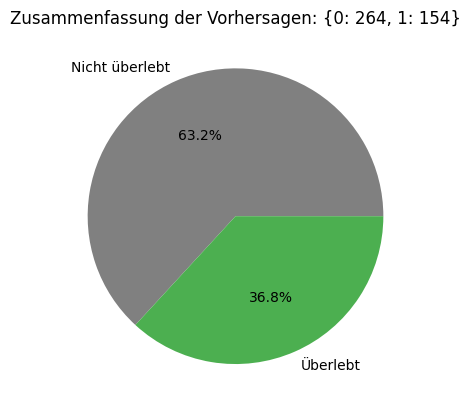

In [7]:
# Test-Daten laden und vorverarbeiten
test_df = pd.read_csv("data/test.csv", dtype=dtypes)
test_processed = preprocess_features(test_df)

# Relevante Features auswählen
X_test = test_processed[X.columns]

# Vorhersagen mit dem optimierten Modell
test_predictions = best_rf_model.predict(X_test)

# Ergebnisse für den Export vorbereiten
submission = pd.DataFrame({
    "PassengerId": test_df['PassengerId'],
    "Name": test_df['Name'],
    "Sex": test_df['Sex'],
    "Survived": test_predictions,
})

# Optimierte CSV-Speicherung ohne Indexspalte und mit effizienter Kompression
submission.to_csv("submission_rf.csv", index=False, encoding='utf-8')

# Anzeigen der ersten Datensätze der Vorhersage
display(submission.head(10))

# Erstelle Pie Chart zur Visualiserung der Vorhersage
survivors = submission['Survived'].value_counts().to_dict()
piechart = np.array([survivors.get(0), survivors.get(1)])
survlabels = ["Nicht überlebt", "Überlebt"]
survcolors = ["grey", "#4CAF50"]
plt.title(f"Zusammenfassung der Vorhersagen: {submission['Survived'].value_counts().to_dict()}")
plt.pie(piechart, labels = survlabels, colors = survcolors, autopct='%1.1f%%')
plt.show() 